# GATE (Sinogram Reconstruction; With Time of Flight)

In [1]:
from __future__ import annotations
import torch
import pytomography
from pytomography.metadata import ObjectMeta
from pytomography.metadata.PET import PETTOFMeta, PETSinogramPolygonProjMeta
from pytomography.projectors.PET import PETSinogramSystemMatrix
from pytomography.algorithms import OSEM
from pytomography.io.PET import gate
from pytomography.likelihoods import PoissonLogLikelihood
import os
from pytomography.transforms.shared import GaussianFilter
import matplotlib.pyplot as plt
from pytomography.utils import sss
import gc


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_c.so.1.8.0
    parallelproj CUDA lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_cuda.so.1.8.0
    


During this script, some ROOT files generated from gate are saved as .pt tensors throughout the process. Since reading the ROOT files takes considerable time, it is recommended to just open the generated .pt files in subsequent runs of this script:

In [2]:
LOAD_FROM_ROOT = False # Set to true if .pt files not generated

Required data:

In [3]:
path = '/disk1/pet_mri_scan/'
# Macro path where PET scanner geometry file is defined
macro_path = os.path.join(path, 'mMR_Geometry.mac')
# Get information dictionary about the scanner
info = gate.get_detector_info(path = macro_path,
    mean_interaction_depth=9, min_rsector_difference=0)
# Paths to all ROOT files containing data
paths = [os.path.join(path, f'gate_simulation/all_physics/mMR_voxBrain_{i}.root') for i in range(1, 55)]; del(paths[23]) #path 23 corrupted

Set up time of flight metadata:
* Since GATE tracks the times, the time of flight bins can be set up however one wishes. The only thing that is dependent on the GATE simulation is `fwhm_tof_resolution`, which in our case is 550ps

In [4]:
speed_of_light = 0.3 #mm/ps
fwhm_tof_resolution = 550 * speed_of_light / 2 #ps to position along LOR
TOF_range = 1000 * speed_of_light #ps to position along LOR (full range)
num_tof_bins = 5
tof_meta = PETTOFMeta(num_tof_bins, TOF_range, fwhm_tof_resolution, n_sigmas=3)

## Normalization Correction

In PET imaging, each detector crystal used in the scanner will have a different response to a uniform source due to its positioning (e.g. crystals at the end of edge of modules are different than those in the center). Adequate PET reconstruction takes this into account by first performing a calibration scan for a scanner and obtaining a normalization correction factor for each crystal pair LOR

**The cell below only needs to be ran once**, and may take a long time, as it requires opening and parsing through all the ROOT files corresponding to the normalization scan. Once it is ran, the normalization weights corresponding to each pair of detector IDs will be obtained (due to geometry/crystal orientation).

 This particular calibration scan was done using a thin cylindrical shell. We can compute $\eta$ using a particular function in the gate functionality of PyTomography. Then we save it as a `torch.Tensor` file for easy access in the next part. For this we need

* `cylinder_radius`: The radius of the thin cylindrical shell used for calibration

In [5]:
if LOAD_FROM_ROOT:
    normalization_paths = [os.path.join(path, f'normalization_scan/mMR_Norm_{i}.root') for i in range(1,37)]

    # Get eta in listmode format
    normalization_weights = gate.get_normalization_weights_cylinder_calibration(
        normalization_paths,
        info,
        cylinder_radius = 318, # mm (radius of calibration cylindrical shell,
        include_randoms=False 
    )

    normalization_sinogram = gate.get_norm_sinogram_from_listmode_data(normalization_weights, macro_path)
    torch.save(normalization_sinogram, os.path.join(path, 'normalization_sinogram.pt'))
normalization_sinogram = torch.load(os.path.join(path, 'normalization_sinogram.pt'))

## Primary-Only Reconstruction

Before we delve into scatter/random modeling, lets get a baseline reconstruction that uses only primary events from the simulated GATE data. We can use PyTomography functionality to select for such events when we open the ROOT data. Obviously this is not doable for clinical data (where we don't know which events are randoms/scatters).

In [6]:
if LOAD_FROM_ROOT:
    detector_ids = gate.get_detector_ids_from_root(
        paths,
        info,
        tof_meta = tof_meta,
        include_randoms=False,
        include_scatters=False)
    detector_ids = detector_ids[detector_ids[:,2]>-1] # For TOF, only take events within the TOF bins
    torch.save(detector_ids, os.path.join(path, 'detector_ids_tof_primary_only.pt'))
detector_ids = torch.load(os.path.join(path, 'detector_ids_tof_primary_only.pt'))

Lets also get the true scatters and randoms from this data so we can compare our estimation:

In [7]:
if LOAD_FROM_ROOT:
    detector_ids_randoms_true = gate.get_detector_ids_from_root(
        paths,
        info,
        tof_meta = tof_meta,
        randoms_only=True)
    detector_ids_scatters_true = gate.get_detector_ids_from_root(
        paths,
        info,
        tof_meta = tof_meta,
        scatters_only=True)
    detector_ids_randoms_true = detector_ids_randoms_true[detector_ids_randoms_true[:,2]>-1] # For TOF, only take events within the TOF bins
    detector_ids_scatters_true = detector_ids_scatters_true[detector_ids_scatters_true[:,2]>-1] # For TOF, only take events within the TOF bins
    torch.save(detector_ids_randoms_true, os.path.join(path, 'detector_ids_randoms_true.pt'))
    torch.save(detector_ids_scatters_true, os.path.join(path, 'detector_ids_scatters_true.pt'))
detector_ids_randoms_true = torch.load(os.path.join(path, 'detector_ids_randoms_true.pt'))
detector_ids_scatters_true = torch.load(os.path.join(path, 'detector_ids_scatters_true.pt'))

We can convert the loaded listmode events into sinogram format using the following:
* Note: PyTomography currently only has basic sinogram binning functionality with no mashing / data reduction

In [8]:
sinogram = gate.listmode_to_sinogram(detector_ids, info, tof_meta=tof_meta)

We reconstruct TOF data as follows (the only difference between non-TOF is specifing the `tof_meta` in the `proj_meta`):
* Note: in this case, our sensitivity sinogram `sinogram_sensitivity ` only has contribution from the normalization factor $\eta$ (and not attenuation $\mu$), so we need to include the attenuation map in the system matrix to get the true sensitivity weights

In [9]:
# Specify object space for reconstruction
object_meta = ObjectMeta(
    dr=(2,2,2), #mm
    shape=(128,128,96) #voxels
)
# Get projection space metadata from PET geometry information dictionary and TOF metadata
proj_meta = PETSinogramPolygonProjMeta(info, tof_meta=tof_meta)
# Get attenuation map and PSF transform from the associated phantom
atten_map = gate.get_attenuation_map_nifti('/disk1/pet_mri_scan/fdg_pet_phantom_umap.nii.gz', object_meta).to(pytomography.device)
psf_transform = GaussianFilter(4) # 2mm gaussian blurring
# Create system matrix.
system_matrix = PETSinogramSystemMatrix(
       object_meta,
       proj_meta,
       obj2obj_transforms = [psf_transform],
       sinogram_sensitivity = normalization_sinogram,
       N_splits=10,
       attenuation_map=atten_map,
       device='cpu' # projections output on cpu, computation is still on GPU
)
# Create likelihood
likelihood = PoissonLogLikelihood(
    system_matrix,
    sinogram,
)
# Reconstruct
recon_algorithm = OSEM(likelihood)
recon_primaryonly = recon_algorithm(n_iters=2, n_subsets=24)
# delete to save memory
del(sinogram) 
del(system_matrix) 
del(likelihood)
del(recon_algorithm) 
gc.collect()

20

And plot:

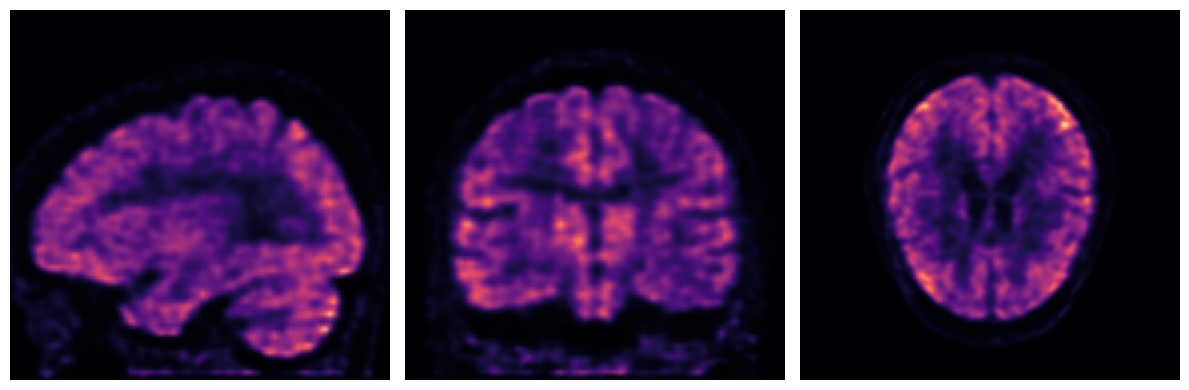

In [10]:
vmax = 0.15
fig, ax = plt.subplots(1,3,figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(recon_primaryonly[48,16:-16].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.pcolormesh(recon_primaryonly[16:-16,64].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
plt.subplot(133)
plt.pcolormesh(recon_primaryonly[:,:,48].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
fig.tight_layout()
plt.show()

Note that this is not possible in clinical practice, since we don't know which events are scatters/randoms. The reconstruction above is going to be used as an "ideal" comparison for our reconstruction of all events.

## Reconstruction Correcting For Randoms + Scatters

When time-of-flight information is used, estimation of randoms and scatters slightly changes. Lets first set up the system matrix for reconstruction

In [11]:
if LOAD_FROM_ROOT:
    detector_ids = gate.get_detector_ids_from_root(
        paths,
        info,
        tof_meta=tof_meta
        )
    detector_ids = detector_ids[detector_ids[:,2]>-1] # For TOF, only take events within the TOF bins
    torch.save(detector_ids, os.path.join(path, 'detector_ids_tof_all_events.pt'))
detector_ids = torch.load(os.path.join(path, 'detector_ids_tof_all_events.pt'))

Create sinogram:

In [12]:
sinogram = gate.listmode_to_sinogram(detector_ids, info, tof_meta=tof_meta)

### Randoms

In addition to the first two steps of the non-TOF procedure (obtaining a random sinogram and smoothing), we now also need to account for the fact that the number of randoms in each TOF bin is proportional to the length of the TOF bin divided by the total coincidence timing width. We can do this using the `randoms_sinogram_to_sinogramTOF` function. We need to provide the `tof_meta`

In [13]:
if LOAD_FROM_ROOT:
    detector_ids_delays = gate.get_detector_ids_from_root(
        paths,
        info,
        substr = 'delay')
    torch.save(detector_ids_delays, os.path.join(path, 'detector_ids_delays.pt'))
detector_ids_delays= torch.load(os.path.join(path, 'detector_ids_delays.pt'))

Apply all techniques to get randoms sinogram estimate:

In [14]:
# Load random events accross all TOF bins
sinogram_randoms_estimate = gate.listmode_to_sinogram(detector_ids_delays, info)
sinogram_randoms_estimate = gate.smooth_randoms_sinogram(sinogram_randoms_estimate, info, sigma_r=4, sigma_theta=4, sigma_z=4)
sinogram_randoms_estimate = gate.randoms_sinogram_to_sinogramTOF(sinogram_randoms_estimate, tof_meta, coincidence_timing_width = 4300) # coinicidence timing window for this GATE simulation was set to 4300ps

### Scatters

Like before (non-TOF sinogram tutorial), lets first get an initial reconstruction without scatter.

In [15]:
atten_map = gate.get_attenuation_map_nifti('/disk1/pet_mri_scan/fdg_pet_phantom_umap.nii.gz', object_meta)
normalization_sinogram = torch.load(os.path.join(path, 'normalization_sinogram.pt')) # assumes this has been saved from the intro tutorial
proj_meta = PETSinogramPolygonProjMeta(info, tof_meta)
psf_transform = GaussianFilter(4)
system_matrix = PETSinogramSystemMatrix(
       object_meta,
       proj_meta,
       obj2obj_transforms = [psf_transform],
       sinogram_sensitivity = normalization_sinogram,
       N_splits=10,
       attenuation_map=atten_map,
       device='cpu' # projections output on cpu, rest is GPU
)
additive_term = sinogram_randoms_estimate / system_matrix._compute_sensitivity_sinogram().cpu()
likelihood = PoissonLogLikelihood(
        system_matrix,
        sinogram,
        additive_term = additive_term
    )
recon_algorithm = OSEM(likelihood)
recon_without_scatter_estimation = recon_algorithm(2,24)

There are two additional parameters we need to provide to the function for TOF:

1. `tof_meta`: Provides all the required TOF metadata
2. `num_dense_tof_bins`: The emission integrals in Watson [CITE] are split into multiple regions: this specifies the number of regions. This is independent and seperate from any of the information in `tof_meta`.

**Note: this takes ~10 minutes to run**

In [16]:
sinogram_scatter_estimate = sss.get_sss_scatter_estimate(
    object_meta = object_meta,
    proj_meta = proj_meta,
    pet_image = recon_without_scatter_estimation,
    attenuation_image = atten_map,
    system_matrix = system_matrix,
    proj_data = sinogram,
    image_stepsize = 4,
    attenuation_cutoff = 0.004,
    sinogram_interring_stepsize = 4,
    sinogram_intraring_stepsize = 4,
    sinogram_random = sinogram_randoms_estimate,
    tof_meta = tof_meta,
    num_dense_tof_bins = 25
    )

/data/anaconda/envs/pytomo_install_test/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


This TOF sinogram can be compared to the true scatter in each TOF bin. We'll look at summed profiles like we did above.

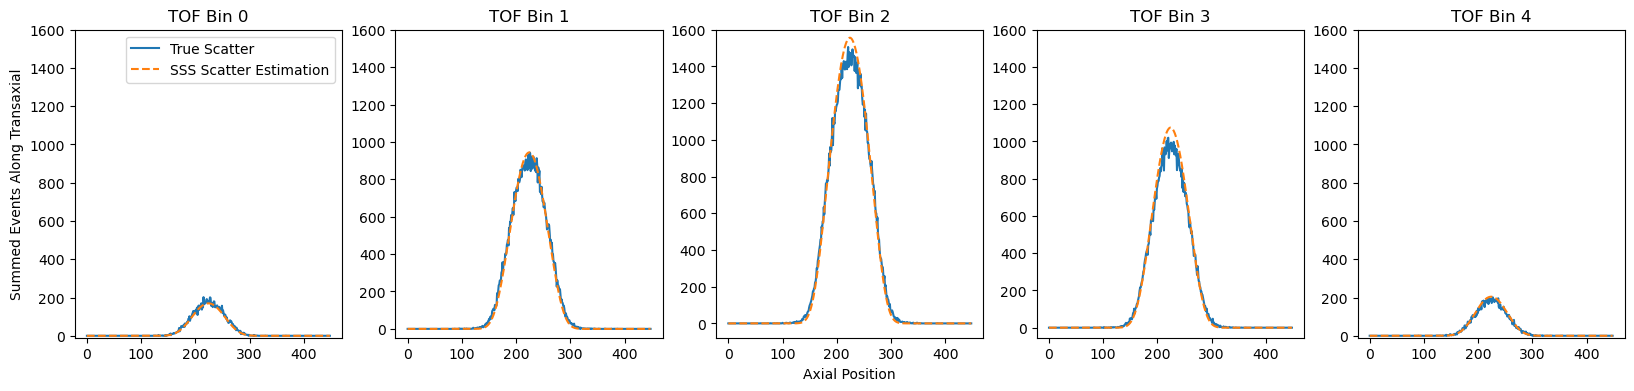

In [17]:
sinogram_scatters_true = gate.listmode_to_sinogram(detector_ids_scatters_true, info, tof_meta=tof_meta)

fig, ax = plt.subplots(1,5,figsize=(20,4))
# loop TOF bins
for i in range(5):
    ax[i].plot(sinogram_scatters_true[:,:,:64,i].sum(dim=(0,2)), label='True Scatter')
    ax[i].plot(sinogram_scatter_estimate[:,:,:64,i].sum(dim=(0,2)), ls='--', label='SSS Scatter Estimation')
    ax[i].set_title(f'TOF Bin {i}')
    ax[i].set_ylim(top=1600)
ax[0].legend()
ax[2].set_xlabel('Axial Position')
ax[0].set_ylabel('Summed Events Along Transaxial')
plt.show()

From the estimated scatter sinogram we can then reconstruct by constructing an additive term like before (non-TOF sinogram tutorial)

In [18]:
additive_term = (sinogram_randoms_estimate + sinogram_scatter_estimate) / system_matrix._compute_sensitivity_sinogram().cpu()
likelihood = PoissonLogLikelihood(
        system_matrix,
        sinogram,
        additive_term = additive_term
    )
recon_algorithm = OSEM(likelihood)
recon_sinogram_TOF = recon_algorithm(2,24)

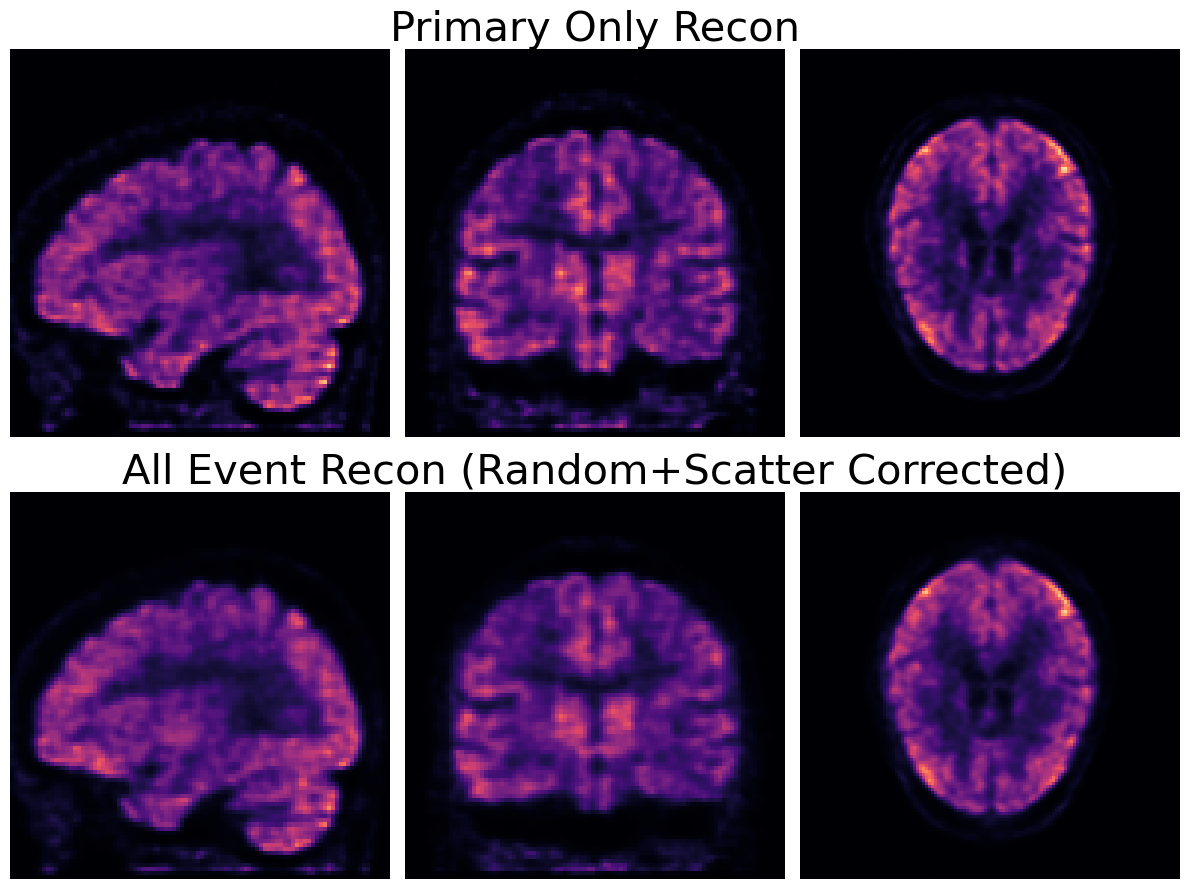

In [19]:
vmax = 0.15
fig, ax = plt.subplots(2,3,figsize=(12,9))
plt.subplot(231)
plt.pcolormesh(recon_primaryonly[48,16:-16].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
plt.subplot(232)
plt.pcolormesh(recon_primaryonly[16:-16,64].cpu().T, cmap='magma', vmax=vmax)
plt.title('Primary Only Recon', fontsize=30)
plt.axis('off')
plt.subplot(233)
plt.pcolormesh(recon_primaryonly[:,:,48].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
plt.subplot(234)
plt.pcolormesh(recon_sinogram_TOF[48,16:-16].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
plt.subplot(235)
plt.pcolormesh(recon_sinogram_TOF[16:-16,64].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
plt.title('All Event Recon (Random+Scatter Corrected)', fontsize=30)
plt.subplot(236)
plt.pcolormesh(recon_sinogram_TOF[:,:,48].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
fig.tight_layout()
plt.show()